<a href="https://colab.research.google.com/github/kevinball02/HUFS-ML-Project/blob/master/Gaussian_Mixture_Model_KYH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Process

## Basic Settings

깃허브에 저장된 API Token을 가져와, kaggle API 커맨드를 실행하여  
데이터를 다운 받자.

In [1]:
!git clone 'https://github.com/kevinball02/HUFS-ML-Project.git'

!mkdir -p ~/.kaggle
!mkdir -p ./result
!mv HUFS-ML-Project/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Cloning into 'HUFS-ML-Project'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 74 (delta 19), reused 7 (delta 0), pack-reused 0
Unpacking objects: 100% (74/74), 6.29 MiB | 6.09 MiB/s, done.


In [2]:
! kaggle datasets download -d mirichoi0218/insurance
! unzip insurance.zip

  0% 0.00/16.0k [00:00<?, ?B/s]
100% 16.0k/16.0k [00:00<00:00, 34.8MB/s]
Archive:  insurance.zip
  inflating: insurance.csv           


In [3]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib_inline.backend_inline import set_matplotlib_formats
import seaborn as sns

set_matplotlib_formats('svg')
plt.rcParams['axes.edgecolor'] = 'black'
sns.set_style("whitegrid")

## EDA

In [4]:
raw_data = pd.read_csv('./insurance.csv')
raw_data.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


In [5]:
data = raw_data[['age','charges']] # 2차원 데이터 추출

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   age      1338 non-null   int64  
 1   charges  1338 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 21.0 KB


In [7]:
data.describe()

,age,charges
count,1338.000000,1338.000000
mean,39.207025,13270.422265
std,14.049960,12110.011237
min,18.000000,1121.873900
25%,27.000000,4740.287150
50%,39.000000,9382.033000
75%,51.000000,16639.912515
max,64.000000,63770.428010


In [8]:
data.duplicated().sum()

1

In [9]:
data.drop_duplicates(inplace=True) # 중복 샘플 제거
print(len(data))

1337


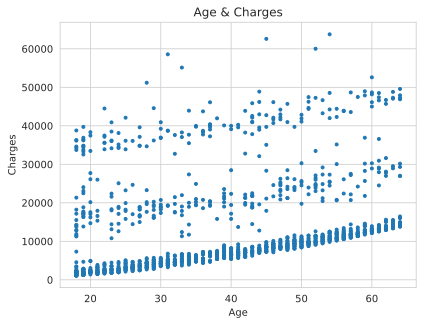

In [10]:
plt.scatter(data['age'], data['charges'], marker='.')

plt.title("Age & Charges")
plt.xlabel("Age")
plt.ylabel("Charges")

plt.show()

In [11]:
from sklearn.preprocessing import RobustScaler

rbs = RobustScaler()
data_scaled = rbs.fit_transform(data)

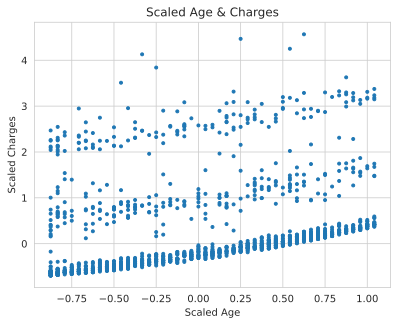

In [12]:
plt.scatter(data_scaled[:,0], data_scaled[:,1], marker='.')

plt.title("Scaled Age & Charges")
plt.xlabel("Scaled Age")
plt.ylabel("Scaled Charges")

plt.show()

## Create GMM from AIC & BIC.

In [13]:
from sklearn.mixture import GaussianMixture

X = data.copy()
n_components = np.arange(2, 21)

models = [
    GaussianMixture(n, covariance_type='full', random_state=31).fit(X)
    for n in n_components
    ]

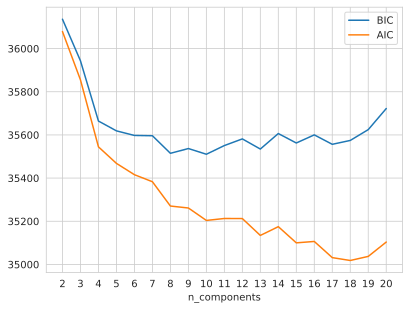

In [14]:
plt.plot(n_components, [m.bic(X) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X) for m in models], label='AIC')
plt.xticks(np.arange(2,21,1))

plt.legend(loc='best')
plt.xlabel('n_components')

plt.show()

위의 그림의 BIC에서, 10개를 가장 적합한 mixture 개수로 정하였다.

In [15]:
gmm = GaussianMixture(n_components=10, covariance_type="full", random_state=31).fit(X)
labels = gmm.predict(X) # 최종 클러스터 라벨링

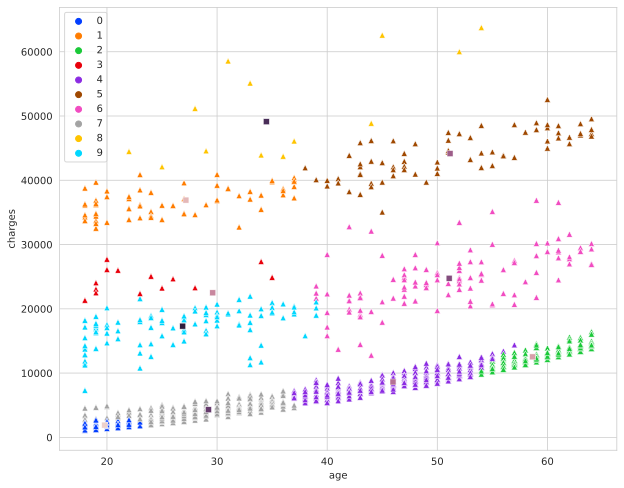

In [16]:
plt.figure(figsize=(10,8))

sns.scatterplot(x=X['age'], y=X['charges'],
                hue=labels, palette="bright",
                marker='^', legend='brief')

centroids = gmm.means_
sns.scatterplot(x=centroids[:,0], y=centroids[:,1],
                hue=np.unique(labels), legend=False,
                marker='s') # Centroids

plt.legend(loc='best')
plt.show()

위의 그림에서,  
사각형: 각 군집의 centroid  
삼각형: 군집에 속한 샘플

## Arbitrary Sampling

In [17]:
from sklearn.datasets import make_blobs

sample_X, sample_y = make_blobs(n_samples=5, n_features=2,
                                centers=centroids, cluster_std=4,
                                random_state=31)
# sample_X: 5-samples의 좌표
# sample_y: 각 sample이 속한 cluster의 label 값 (0~9)

위에서 만든 mixture model에서,  
10-centroids를 기준으로 군집 표준편차가 4인 임의의 5-samples를 설정했다.

In [18]:
print(sample_X) # 5-samples

[[5.77749521e+01 1.25227153e+04]
 [2.74952440e+01 3.69169354e+04]
 [4.31530687e+01 8.62123729e+03]
 [2.65013968e+01 2.24961719e+04]
 [1.81322002e+01 1.91059916e+03]]


In [19]:
print(sample_y) # labels

[2 1 4 3 0]


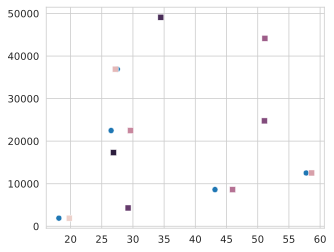

In [20]:
plt.figure(figsize=(5,4))

sns.scatterplot(x=sample_X[:,0], y=sample_X[:,1],
                palette="bright", legend=False)

sns.scatterplot(x=centroids[:,0], y=centroids[:,1],
                hue=np.unique(labels), legend=False,
                marker='s') # Centroids

plt.show()

위의 그림에서, 파란색 점이 임의로 추출된 5-samples이다.

In [21]:
sample_preds = gmm.predict(sample_X)

In [22]:
# Evaluation
print(sample_y)
print(sample_preds)

[2 1 4 3 0]
[2 1 4 3 0]


따라서, 생성한 gmm 모델이 5개의 점을 잘 예측하였다.

## Detect Outliers

다음은, 백분위수를 기준으로 이상치를 탐지하는 작업이다.

In [23]:
densities = gmm.score_samples(X)
density_threshould = np.percentile(densities, 2) # 2% 밀도 임계값
outliers = X[densities < density_threshould]
outlier_labels = gmm.predict(outliers)

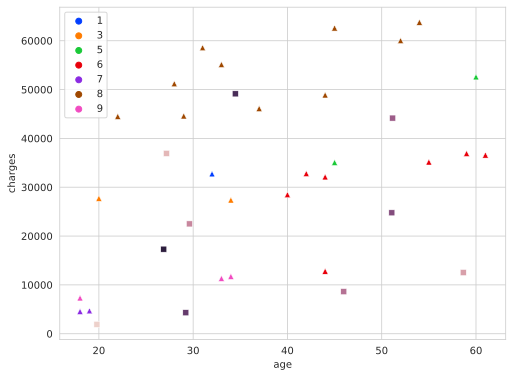

In [24]:
plt.figure(figsize=(8,6))

sns.scatterplot(x=outliers['age'], y=outliers['charges'],
                hue=outlier_labels, palette="bright",
                marker='^', legend='brief') # outliers

sns.scatterplot(x=centroids[:,0], y=centroids[:,1],
                hue=np.unique(labels), legend=False,
                marker='s') # Centroids

plt.legend(loc='best')
plt.show()

In [25]:
len(outliers)

27

위에서, 27개의 outlier가 확인되었다.